<a href="https://colab.research.google.com/github/DonnaVakalis/nano/blob/master/Gapminder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: What does global inequality look like around the world, as tracked by the GINI coefficient?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

**Questions posed:**
###1) Which countries have the highest/lowest average GINI coefficient (on average, for the last ten years)? 
###2) Which direction are GINI coefficients moving (for the last 50 years) worldwide?
###3) Within the U.S. how do the GINI coefficients compare at the state-level to the country as a whole?


**Datasets:** 

GINI world downloaded from https://www.gapminder.org/data/

USA downloaded from https://en.wikipedia.org/wiki/List_of_U.S._states_by_Gini_coefficient 


<a id='wrangling'></a>
## Data Wrangling


### LOAD DATA


In [1]:
# Install pycountry
!pip install pycountry

# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import pycountry
from functools import reduce #for merging dataframes
import plotly.express as px

# Settings
%matplotlib inline 
pd.options.display.float_format = '{:,.2f}'.format # display numbers with two decimal places

     |████████████████████████████████| 10.1MB 539kB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=8327ab08a614225eebc4c5b29c85ffca66365f9551b84b5dd69e09ccf30c0dbc
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Load the data
base_dir = "/content/gdrive/My Drive/Colab Notebooks/project_gapminder/"

In [4]:
# GINI coefficients Global
file = base_dir + 'gini.csv' # from https://www.gapminder.org/data/
df_gini = pd.read_csv(file) # Read GINI --< CSV format

# GINI coefficients USA by State
file = base_dir + 'Gini_state_by_state.csv' # from https://en.wikipedia.org/wiki/List_of_U.S._states_by_Gini_coefficient
df_gini_USA = pd.read_csv(file) # Read States GINI --< CSV format

In [5]:
# USA State 2-letter USPS codes
file = base_dir + 'StateCodes.csv'  #from https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations
df_codesUSA = pd.read_csv(file)
df_codesUSA.head()

,Name,USPS
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [6]:
# View types and look for shape, types and instances of missing or possibly errant data 
df_gini.head()
df_gini.info()
#df_gini
list_countries = df_gini['country'].unique().tolist()
len(list_countries)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Columns: 242 entries, country to 2040
dtypes: float64(241), object(1)
memory usage: 368.8+ KB


195

comments about df_gini:
- years range from 1800 to 2040 (which doesn't make any sense to me...)
- 195 countries
- this data set is full! i.e., no missing values for the countries and years given.
- notice many more years than other datasets explored from gapminder
- consider limiting scope of question to "last 20 years" + read more about how gini is calculated

In [46]:
# types and look for shape, types and instances of missing or possibly errant data in the States
df_gini_USA.head()
df_gini_USA.info()
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   52 non-null     object 
 1   GINI    52 non-null     float64
dtypes: float64(1), object(1)
memory usage: 960.0+ bytes



comments about df_gini_USA:

- year of data is 2010
- all 50 States present i.e., no missing values for the countries and years given.
- will need to add 2-letter USPS State codes

 
### Data Cleaning
---
For Global Data: truncating to years of interest (1970-2020), Create column with average, Create column with delta for last 50 years, getting 3-letter country codes, Get the U.S. GINI from 2010

In [7]:
# Select "country" and years "1970" to "2020" within gini dataframe
cols_to_keep = np.r_[0, 171:222] #there are 242 columns beginning with 'country' then 1840...
df_g = df_gini.iloc[:,cols_to_keep]
df_g.head()

,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,30.50,30.80,31.20,31.60,31.90,32.10,32.20,32.20,32.20,32.20,32.20,32.10,32.00,32.10,32.50,33.00,33.70,34.70,35.40,36.00,36.40,36.70,36.70,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80
1,Albania,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,27.00,27.00,27.00,27.00,27.00,27.20,27.50,28.00,28.60,29.40,30.20,30.70,31.00,31.10,31.00,30.70,30.40,30.20,30.00,29.70,29.50,29.30,29.10,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00
2,Algeria,39.90,39.90,39.90,40.00,40.00,40.00,40.00,40.00,40.00,40.10,40.10,40.10,40.10,40.10,40.10,40.10,40.20,40.00,39.80,39.40,38.80,38.10,37.40,36.70,36.10,35.50,34.90,34.40,34.00,33.50,33.10,32.60,32.20,31.70,31.20,30.80,30.30,29.90,29.40,29.00,28.50,28.20,27.90,27.70,27.60,27.60,27.60,27.60,27.60,27.60,27.60
3,Andorra,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00
4,Angola,54.80,54.70,54.60,54.50,54.40,54.40,54.30,54.20,54.10,54.00,53.90,53.80,53.70,53.60,53.50,53.40,53.30,53.20,53.10,53.00,52.90,52.80,52.80,52.70,52.60,52.50,52.40,52.30,52.20,52.10,51.80,51.30,50.60,49.70,48.50,47.30,46.20,45.00,44.10,43.40,42.90,42.70,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60


In [8]:
# Create new variables such as recent average and overall change
df_ = df_g.assign(
                    recent_mean = df_gini.iloc[:,-11:].mean(axis=1, numeric_only=True), # Create the average for last 10 years (2010-2020)
                    delta = df_gini['1970'] - df_gini['2020']  # Calculate the difference since 1970 (positive is decreased GINI, which means better equality)
)

In [9]:
# Get 3-letter country codes and make it column "iso_alpha"

# print(list_countries) # Uncomment to see list of countries
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        print('could not add ISO 3 code for ->', country)
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})
        
 # create a new column iso_alpha in the df
# and fill it with appropriate iso 3 code
for c_name, c_code in d_country_code.items():
    df_.loc[(df_.country == c_name), 'iso_alpha'] = c_code

df_.head()


could not add ISO 3 code for -> Cape Verde
could not add ISO 3 code for -> Congo, Dem. Rep.
could not add ISO 3 code for -> Congo, Rep.
could not add ISO 3 code for -> Micronesia, Fed. Sts.
could not add ISO 3 code for -> North Korea
could not add ISO 3 code for -> South Korea
could not add ISO 3 code for -> St. Kitts and Nevis
could not add ISO 3 code for -> St. Lucia
could not add ISO 3 code for -> St. Vincent and the Grenadines
could not add ISO 3 code for -> Swaziland


,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,recent_mean,delta,iso_alpha
0,Afghanistan,30.50,30.80,31.20,31.60,31.90,32.10,32.20,32.20,32.20,32.20,32.20,32.10,32.00,32.10,32.50,33.00,33.70,34.70,35.40,36.00,36.40,36.70,36.70,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,-6.30,AFG
1,Albania,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,27.00,27.00,27.00,27.00,27.00,27.20,27.50,28.00,28.60,29.40,30.20,30.70,31.00,31.10,31.00,30.70,30.40,30.20,30.00,29.70,29.50,29.30,29.10,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,-2.20,ALB
2,Algeria,39.90,39.90,39.90,40.00,40.00,40.00,40.00,40.00,40.00,40.10,40.10,40.10,40.10,40.10,40.10,40.10,40.20,40.00,39.80,39.40,38.80,38.10,37.40,36.70,36.10,35.50,34.90,34.40,34.00,33.50,33.10,32.60,32.20,31.70,31.20,30.80,30.30,29.90,29.40,29.00,28.50,28.20,27.90,27.70,27.60,27.60,27.60,27.60,27.60,27.60,27.60,27.60,12.30,DZA
3,Andorra,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,0.00,AND
4,Angola,54.80,54.70,54.60,54.50,54.40,54.40,54.30,54.20,54.10,54.00,53.90,53.80,53.70,53.60,53.50,53.40,53.30,53.20,53.10,53.00,52.90,52.80,52.80,52.70,52.60,52.50,52.40,52.30,52.20,52.10,51.80,51.30,50.60,49.70,48.50,47.30,46.20,45.00,44.10,43.40,42.90,42.70,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60,12.20,AGO


In [10]:
# we must manually add ISO 3 code for North Korea, South Korea, Swaziland, Congo, Dem. Rep. and Congo, Rep. ...
missing = {'North Korea':'PRK','South Korea':'KOR','Congo, Dem. Rep.':'COD','Congo, Rep.':'COG','Swaziland':'SWZ','Niger':'NER'}
for country_name,code in missing.items():
    df_.loc[(df_.country==country_name),'iso_alpha'] = code

df_[df_['country']=='Swaziland'].iso_alpha #check

df_[df_['country']=='Niger'].iso_alpha #check

124    NER
Name: iso_alpha, dtype: object

---

For U.S. Data: create a timeline with just US, create get 3-letter state codes, create a column with delta from country as a whole in 2010 (from Global data)

In [11]:
# Convert the US data from wide to tall format
US_wide = df_gini.query('country=="United States"')
 
# Convert long to tall dataframe
US_long= US_wide.melt(id_vars=["country"],
             var_name="year", # stack years vertically
             value_name='gini')  # insert the value for each year into new column

In [32]:
# For States data, inser the 2-letter State codes
df1 = df_codesUSA.copy()
df2 = df_gini_USA.copy() 
US_long_USPS = pd.merge(df1, df2, left_on='Name ', right_on='State', how='inner') # merge Gini info with USPS state code
US_long_USPS.drop('State', axis=1,inplace=True) # get rid of extra copy of State name
 

,Name,USPS,GINI
0,Alabama,AL,0.48
1,Alaska,AK,0.41
2,Arizona,AZ,0.47
3,Arkansas,AR,0.47
4,California,CA,0.49
5,Colorado,CO,0.46
6,Connecticut,CT,0.49
7,Delaware,DE,0.45
8,District of Columbia,DC,0.54
9,Florida,FL,0.49


<a id='eda'></a>
## Exploratory Data Analysis


### What does the GINI coefficient look like today over the globe?


In [38]:
df_.sort_values(by='recent_mean',ascending=True, inplace=True)
#df_.head() #Best country is Ukraine (24.89, and better than in 1970) and Slovenia, followed by Czech Rep. and Moldova
df_.tail() #Worst country is South Africa (63.10, but better today than in 1970) bested by Suriname, Botswana, Namibia and Zambia...

,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,recent_mean,delta,iso_alpha
193,Zambia,68.20,68.30,68.50,68.70,68.80,69.00,69.20,69.40,69.60,69.50,69.20,68.70,67.90,66.90,65.80,64.80,63.80,62.80,61.70,61.10,59.80,58.00,56.10,54.10,51.70,50.10,49.40,48.70,48.00,47.40,46.30,44.90,45.00,46.60,48.50,50.70,53.30,54.70,55.00,55.30,55.60,55.90,56.20,56.50,56.80,57.00,57.10,57.10,57.10,57.10,57.10,57.10,11.10,ZMB
118,Namibia,49.30,49.90,50.70,51.70,52.70,53.80,54.80,55.90,56.90,58.00,59.00,60.00,61.10,62.10,63.20,64.20,65.30,66.30,67.30,68.40,69.40,70.50,71.10,71.40,71.20,70.70,69.80,68.90,67.90,67.00,66.10,65.20,64.40,63.80,63.30,62.80,62.50,62.10,61.80,61.40,61.00,60.70,60.30,60.00,59.70,59.50,59.30,59.10,59.10,59.10,59.10,59.10,-9.80,NAM
22,Botswana,53.80,53.80,53.90,53.90,53.90,53.90,54.00,54.00,54.00,54.00,54.10,54.10,54.10,54.10,54.20,54.40,54.70,55.20,55.90,56.70,57.50,58.30,59.10,59.90,60.60,61.20,61.70,62.10,62.50,63.00,63.40,63.90,64.10,64.10,63.90,63.50,62.90,62.30,61.70,61.20,60.80,60.60,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,-6.70,BWA
166,Suriname,48.60,49.00,49.30,49.60,49.90,50.20,50.50,50.80,51.10,51.40,51.70,52.00,52.40,52.70,53.00,53.30,53.60,53.90,54.20,54.50,54.80,55.10,55.40,55.80,56.10,56.40,56.70,57.00,57.30,57.60,57.90,58.20,58.50,58.80,59.10,59.50,59.80,60.10,60.40,60.60,60.80,60.90,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,-12.40,SUR
157,South Africa,68.50,68.40,68.20,67.90,67.60,67.30,67.00,66.70,66.40,66.10,65.80,65.40,65.00,64.60,64.20,63.80,63.40,63.00,62.60,62.10,61.60,60.90,60.40,60.10,60.00,60.00,60.10,59.90,59.50,58.90,58.80,59.20,60.00,61.30,62.60,63.40,63.90,63.90,63.60,63.40,63.30,63.20,63.20,63.20,63.10,63.10,63.00,63.00,63.00,63.00,63.00,63.00,5.50,ZAF


In [39]:
fig = px.choropleth(df_, locations="iso_alpha",
                    color="recent_mean", # column for average last 10 years
                    hover_name="country", # column to add to hover information,
                    title = "GINI coefficients by country",
                    color_continuous_scale=px.colors.sequential.PuRd)
fig.show()

This is a snapshot of the last 10 year average. The range of the coefficient is from low 20s to mid-60s. Without doing a 'real' test, at first glance it appears that richer countries (Canada, Northern Europe, Australia...) have less inequality, in general, than global South countries (such as most Southern American countries, and Southern-most African countries).  

### Which countries are going up versus down over the last 50 years?

In [40]:
fig = px.choropleth(df_, locations="iso_alpha",
                    color="delta", # difference where positive = decrease in inequality
                    hover_name="country", # column to add to hover information,
                    title = "Country-level changes in income equality between 1970 and 2020",
                    color_continuous_scale=px.colors.sequential.RdBu)
fig.show()

For this map, the countries that have more inequality today than in 1970 are less consistently grouped by continent. E.g., neighbouring countries like Gabon and Cameroom and widely differing trends. Looking at the last map and this one together, there doesn't appear to be any obvious association between current levels and the difference over the last 50 years.



### Delve into one country: for U.S. what does it look like over time, and what are GINI coefficients at state level?

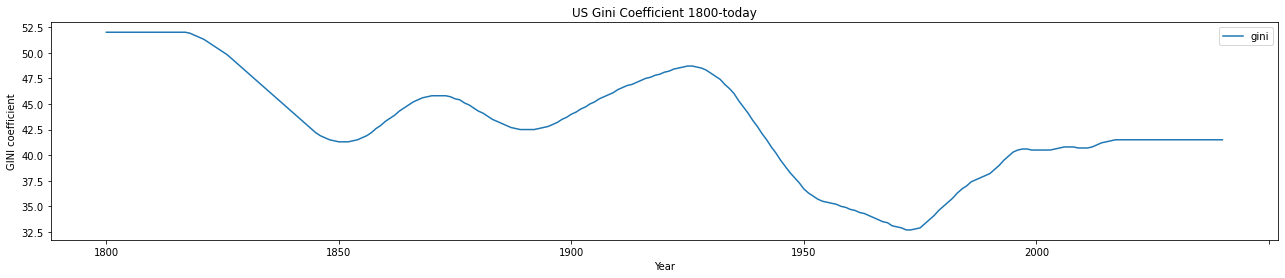

In [64]:
#Look at the US data from 1950 to today
timeline = pd.DataFrame(US_long,columns=['year','gini'])

timeline.plot(x ='year', y='gini', figsize=(22,4), kind = 'line')
 
plt.title('US Gini Coefficient 1800-today')
plt.xlabel('Year')
plt.ylabel('GINI coefficient')
plt.show()

The timeline above shows a non-monotonic pattern, i.e., it has both increased and decreased at various points in time. A future exploration of interest would be to add markers of important policy events in the history of the U.S. to show the time-alignment with the direction and levels of inequality. 

In [52]:
# Look at 2010: Compare the individual states 
fig = px.choropleth(US_long_USPS,
                    locations="USPS", 
                    locationmode="USA-states", 
                    color="GINI",
                    scope="usa",
                    hover_name="Name ",
                    title = "USA GINI coefficients by state, in 2010",
                    color_continuous_scale=px.colors.sequential.PuRd)
fig.show()


In [ ]:
#What is the state-level average versus the country-level average?

def gini_ave(dat1):
    """
    This function prints out a boxplot of the average gini for the given inputs 
    """
    
    df

gini_ave('Paul')

<a id='conclusions'></a>
## Conclusions

 
 
**Questions posed:**

1) Which countries have the highest/lowest average GINI coefficient (on average, for the last ten years)?

Answers: Best country is Ukraine (24.89, and better than in 1970) and Slovenia, followed by Czech Rep. and Moldova. The worst country is South Africa (63.10, but better today than in 1970) bested by Suriname, Botswana, Namibia and Zambia. This is a snapshot of the last 10 year average. The range of the coefficient is from low 20s to mid-60s.

2) Which direction are GINI coefficients moving (for the last 50 years) worldwide?

Answers: The countries that have more inequality today than in 1970 are less consistently grouped by continent. E.g., neighbouring countries like Gabon and Cameroom and widely differing trends. Without doing a 'real' test, at first glance it appears that richer countries (Canada, Northern Europe, Australia...) have less inequality, in general, than global South countries (such as most Southern American countries, and Southern-most African countries). Looking at the two global maps together, there doesn't appear to be any obvious association between current levels and the difference over the last 50 years.

3) Within the U.S. how do the GINI coefficients compare at the state-level to the country as a whole?

Answers: 
Notably, the GINI global dataset says that the US coefficient in 2010 is around 40. But that is the a magitude higher than the within-state coefficients...  So there is some incongruity in how the coefficient is assessment at the national versus regional scale. (See Limitations below). The snapshot of the U.S. shows a low of 0.4063 (Utah) and a high of 0.5229 (New York), thus a spread of about 0.12, which is not as wide of a range as I would have expected. 



**Limitations:** 

The dataset is quite comprehensive, however there is some built-in ambiguity when interpreting the GINI coefficient.  

Based on what I've read here [https://www.investopedia.com/terms/g/gini-index.asp#:~:text=The%20Gini%20coefficient%20is%20equal,the%20line%20of%20perfect%20equality], the coefficient accuracy is dependent on reliable GDP and income data, and furthermore it obscures information about the "shape" of inequality. 


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])